# Equation Recognition

TODO
- Start basic
    - Couple of known classes - numbers, x,y,z, powers, etc. Handwritten dataset, 2-3 layered conv net ontop of pre-trained ImageNet + some filters to detect graph location -> overlay graph in user drawn box. Start with 2D graphs.
        - Use EMNIST dataset which is built into the Pytorch API - refer to tutorial on Transfer learning for computer vision.
- Look into CNN -> BERT . aka, want to get features from CNN and feed into BERT to generate sequence of latex characters that define the written expression. 
    - Question - how to pretrain CNN to extract meaningful features? pretrained? We are essentially replacing our embedding matrix with the CNN extracted features. Sort of One to many because we are feeding it a single image and we expect to see the full output. Wouldn't work as well as many to many because we need the relative sizing and context. 
- Metaclassifier to interpret what to do - graph, solve, simplify, etc

# Extending MNIST

For a first approach, I plan on using transfer learning - likely some ImageNet trained network since those are easily accessible - and then fine tune the upper layers on a dataset of the characters that I plan on being able to detect. These need to be most alphanumerical characters, including symnols for the operators. 

EMNIST is an extended version of the classic MNIST dataset of handwritten characters, however it lacks those aformentioned symbols. As such I need a way of extending this datset. Since the number of classes to add is not large, it would be feasible for me to produce some training data myself, however I want it to not deviate too much from EMNIST. Thus, an interesting question  to ask is how to generate data from limited samples that will match the distribution of existing classes.


In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.EMNIST(
    root="data",
    split='byclass',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.EMNIST(
    root="data",
    split='byclass',
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw


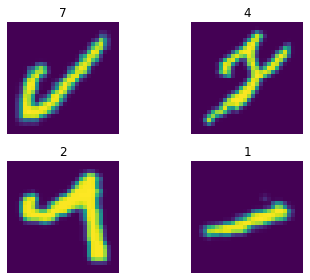

In [3]:
import matplotlib.pyplot as plt
import numpy as np

idxs = np.random.randint(len(training_data), size=4)

fig, ax = plt.subplots(2,2)
fig.set_facecolor('w')

for i, idx in enumerate(idxs):
    img, lbl = training_data[idx]
    img = img.numpy()
    ax[i//2, i%2].imshow(np.reshape(img, img.shape[1:]))
    ax[i//2, i%2].axis('off')
    ax[i//2, i%2].set_title(training_data.classes[lbl])

fig.tight_layout()
plt.show()

In [2]:
print(training_data.classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


We immediately note a problem, there is some form of augmentation already applied to the dataset. This will make it harder to distinguish between say a t and a + or a + and an x. For classifying alphanumeric characters, this augmentation makes sense, since in general these can be invariant to rotation, but that is not the case for my application.

Thus, I'll switch to looking at the classic MNIST. 

## Mean per-Class Images

One of the first ideas that came to mind is to look at what the average picture per class looks like. 

In [5]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



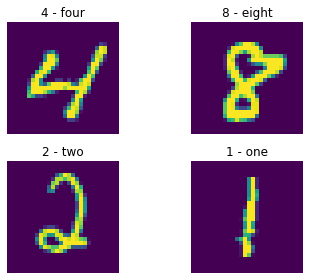

In [6]:
idxs = np.random.randint(len(training_data), size=4)

fig, ax = plt.subplots(2,2)
fig.set_facecolor('w')

for i, idx in enumerate(idxs):
    img, lbl = training_data[idx]
    img = img.numpy()
    ax[i//2, i%2].imshow(np.reshape(img, img.shape[1:]))
    ax[i//2, i%2].axis('off')
    ax[i//2, i%2].set_title(training_data.classes[lbl])

fig.tight_layout()
plt.show()

In [16]:
# No need for these to be Tensors
train_data = training_data.train_data.numpy()
train_labels = training_data.train_labels.numpy()

In [27]:
class_means = {}
for label in np.unique(train_labels):
    idxs = np.where(train_labels == label)
    class_data = train_data[idxs]
    # Take normalized means
    class_means[label] = np.mean(class_data, axis = 0) /255.0
    

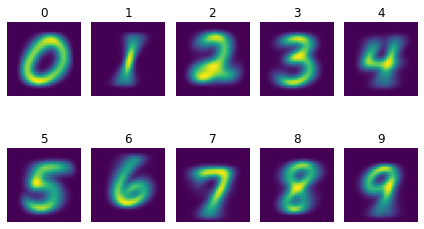

In [30]:
fig, ax = plt.subplots(2,5)
fig.set_facecolor('w')

for i, idx in enumerate(class_means.keys()):
    img = class_means[idx]
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title(idx)

fig.tight_layout()
plt.show()

We can think of each unique element in the training data as a deviation from this mean. For starters, let's quantify deviations of each class from the class mean. To do this, for each image in a class, compute its residual from the mean, and take the average residual value. Then we can look at the distribution of residuals to see if we can find any patterns there.

In [48]:
class_residuals = {}
class_avg_residuals = {}
class_std_residuals = {}

for label in np.unique(train_labels):
    idxs = np.where(train_labels == label)
    class_data = train_data[idxs]/255. # Make sure to normalize
    # Take normalized means
    class_res = np.mean(class_data, axis = 0) - class_data
    class_residuals[label] = class_res
    class_avg_residuals[label] = np.mean(class_res, axis=(1,2))

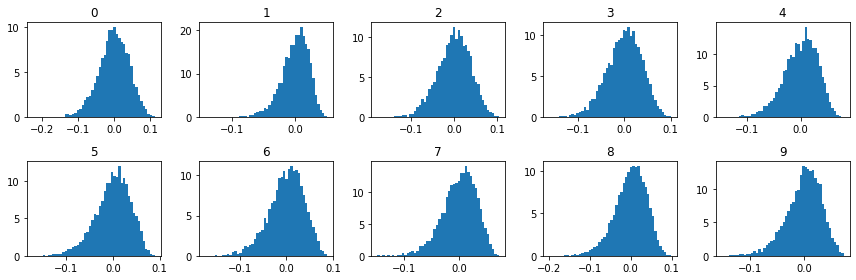

In [47]:
fig, ax = plt.subplots(2,5)
fig.set_size_inches(12,4)
fig.set_facecolor('w')

for i, idx in enumerate(class_means.keys()):
    res = class_avg_residuals[idx]
    ax[i//5, i%5].hist(res, bins=50, density=True)
    #ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title(idx)

fig.tight_layout()
plt.show()

So, one very naive way of generating data based off of few samples, is to use the mean of these samples as our image mean, then apply uniform deviations from this mean by sampling from distributions above. 

Clearly this is not ideal, since the deviations from the mean are not uniform, by highly localized as I'll display. If there were some way of describing this localized deviations, we could then refine our approach 

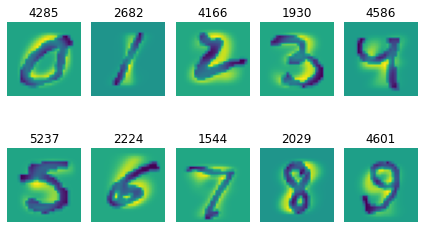

In [49]:
fig, ax = plt.subplots(2,5)
fig.set_facecolor('w')

for i, lbl in enumerate(class_means.keys()):
    idx = np.random.randint(len(class_residuals[lbl]))
    img = class_residuals[lbl][idx]
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title(idx)

fig.tight_layout()
plt.show()